In [15]:
from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler, LabelBinarizer, Imputer, 
    FunctionTransformer,PolynomialFeatures, OrdinalEncoder,
    RobustScaler , PowerTransformer , OneHotEncoder
)
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
data = pd.read_csv("./../Data/income_evaluation.csv")
objcol = data.select_dtypes("object").columns.tolist()
data[objcol] = data[objcol].astype("category")
data.columns = [i.strip() for i in data.columns.tolist()]
data["income"] = data["income"].cat.codes
target = data.pop("income")
num_col = data.select_dtypes("int").columns.tolist()
cat_col = data.select_dtypes("category").columns.tolist()

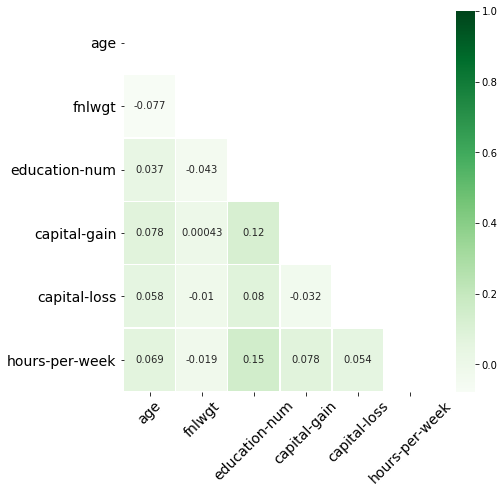

In [17]:
def make_pair_plot(df_corr):
    # Set the default matplotlib figure size to 7x7:
    fix, ax = plt.subplots(figsize=(7,7))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(df_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(df_corr, mask=mask, ax=ax, 
                     annot=True, cmap="Greens", linewidths=.5)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14,rotation=45)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14,rotation=0)
    buttom , top = ax.get_ylim()
    ax.set_ylim(buttom+0.5 , top-0.5)
    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()
    
make_pair_plot(data[num_col].corr())

In [18]:
print(f'num columns : {num_col}')
print(f'cat columns : {cat_col}')

num columns : ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
cat columns : ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [19]:
import sklearn
mapper = DataFrameMapper([
    (["age"],[SimpleImputer(strategy="mean"), StandardScaler()]),
    (["fnlwgt"],[SimpleImputer(strategy="median"), StandardScaler()]),
    (["education-num"],[SimpleImputer(strategy="mean"), RobustScaler()]),
    (["capital-gain","capital-loss"],[SimpleImputer(strategy="median"), PowerTransformer()]),
    (["hours-per-week"],[SimpleImputer(strategy="median"), PowerTransformer()]),
    ####
#     (['workclass', 'education', 'marital-status', 'occupation',
#       'relationship', 'race', 'sex', 'native-country'],
#     [CategoricalImputer(strategy='most_frequent') , OneHotEncoder()]),
    (['workclass'],[CategoricalImputer(strategy='most_frequent') , OneHotEncoder()]),
    (['education'],[CategoricalImputer(strategy='most_frequent'), OneHotEncoder()]),
    (['marital-status'],[CategoricalImputer(strategy='most_frequent') , OneHotEncoder()]),
    (['occupation'],[CategoricalImputer(strategy='most_frequent') , OneHotEncoder()]),
    (['relationship'],[CategoricalImputer(strategy='most_frequent'), OneHotEncoder()]),
    (['race'],[CategoricalImputer(strategy='most_frequent') , OneHotEncoder()]),
    (['native-country'],[CategoricalImputer(strategy='most_frequent') , OneHotEncoder()]),
#     ### PCA
    (['capital-gain', 'capital-loss'], sklearn.decomposition.PCA(1)),
    (['capital-gain', 'capital-loss','hours-per-week'], sklearn.decomposition.KernelPCA(2))
    
] , df_out=True)

In [20]:
class NewTransformer(TransformerMixin):

    def transform(self, X, **transform_params):
        X['new_var'] = X['fnlwgt'] * X['age']
        X = X.drop(columns=['fnlwgt','age'], axis=1)
        return X

    def fit(self, X, y=None, **fit_params):
        return self

In [21]:
pipe = Pipeline([
    ('map', mapper),
    ('feature_gen', NewTransformer())
])
data_1 , data_2 = train_test_split(data , test_size = 0.3)
pipe = pipe.fit(data_1)
pre_data = pipe.transform(data_1)

In [22]:
pre_data[['capital-gain_capital-loss',
 'capital-gain_capital-loss_hours-per-week_0',
 'capital-gain_capital-loss_hours-per-week_1',"new_var"]].head()

,capital-gain_capital-loss,capital-gain_capital-loss_hours-per-week_0,capital-gain_capital-loss_hours-per-week_1,new_var
5158,-1095.793097,-1095.793141,-89.656729,0.002834
6720,3917.199630,3917.200211,-81.109050,-1.038762
19397,-1095.793097,-1095.789117,-89.600219,-0.414176
31449,-1095.793097,-1095.791799,-89.637892,0.029133
2788,-1095.793097,-1095.791799,-89.637892,-0.041284


In [23]:
data.shape , pre_data.shape

((32561, 14), (22792, 108))

In [24]:
print(pre_data.columns.tolist())

['education-num', 'capital-gain_capital-loss_0', 'capital-gain_capital-loss_1', 'hours-per-week', 'workclass_x0_ ?', 'workclass_x0_ Federal-gov', 'workclass_x0_ Local-gov', 'workclass_x0_ Never-worked', 'workclass_x0_ Private', 'workclass_x0_ Self-emp-inc', 'workclass_x0_ Self-emp-not-inc', 'workclass_x0_ State-gov', 'workclass_x0_ Without-pay', 'education_x0_ 10th', 'education_x0_ 11th', 'education_x0_ 12th', 'education_x0_ 1st-4th', 'education_x0_ 5th-6th', 'education_x0_ 7th-8th', 'education_x0_ 9th', 'education_x0_ Assoc-acdm', 'education_x0_ Assoc-voc', 'education_x0_ Bachelors', 'education_x0_ Doctorate', 'education_x0_ HS-grad', 'education_x0_ Masters', 'education_x0_ Preschool', 'education_x0_ Prof-school', 'education_x0_ Some-college', 'marital-status_x0_ Divorced', 'marital-status_x0_ Married-AF-spouse', 'marital-status_x0_ Married-civ-spouse', 'marital-status_x0_ Married-spouse-absent', 'marital-status_x0_ Never-married', 'marital-status_x0_ Separated', 'marital-status_x0_ W